In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-prediction-iti-data-science/sample_submission.csv
/kaggle/input/machine-failure-prediction-iti-data-science/train.csv
/kaggle/input/machine-failure-prediction-iti-data-science/test.csv


## <font color='cyan'>TABLE OF CONTENTS </font>
* [LOADING DATA/LIBRARIES](#chapter1)
* [EDA](#chapter2)
* [Target Vistribution](#section_2_1)
* [Missing Values](#section_2_2)
* [Outliers](#section_2_3)
* [Feature Analysis](#section_2_4)
* [Correlations](#section_2_5)
* [MODELS SETUP/PREDICTIONS](#chapter_3)
* [Setup](#section_3_1)
* [Predictions](#section_3_2)

From the competition page <a>https://www.kaggle.com/competitions/machine-failure-prediction-iti-data-science/overview</a>:<br style="line-height:3;">
**Machine Failure Prediction Competition**<br style="line-height:2;">
Welcome to the Machine Failure Prediction competition! This challenge focuses on leveraging Machine Learning to predict the likelihood of machine failures based on a variety of features. Participants are tasked with creating models that can accurately forecast potential downtimes, enhancing maintenance strategies and reducing operational disruptions.<br style="line-height:5;">
**Competition Overview**<br style="line-height:2;">
In this competition, you will use a dataset containing several features related to machine operation and performance. Your goal is to develop a predictive model that can identify the probability of failure in these machines, enabling preemptive action to avoid costly breakdowns.

<h2 style="color:cyan">LOADING DATA/LIBRARIES</h2><a id="chapter1"></a>

In [2]:
import warnings
warnings.simplefilter(action="ignore")

import time
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, auc

from xgboost import XGBClassifier

In [3]:
train = pd.read_csv("/kaggle/input/machine-failure-prediction-iti-data-science/train.csv", index_col = 'id')
test = pd.read_csv("/kaggle/input/machine-failure-prediction-iti-data-science/test.csv", index_col = 'id')
train.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


<h2 style="color:cyan">EDA</h2><a id="chapter2"></a>

In [4]:
def sep(text, length = 80):
    print('-' * length)
    print(' ' * (length//2) + text.upper())
    print('-' * length)

In [5]:
sep('train')
display(train.info())
sep('test')
display(test.info())

--------------------------------------------------------------------------------
                                        TRAIN
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                  

None

--------------------------------------------------------------------------------
                                        TEST
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   TWF                      10000 non-null  int64  
 8   HDF                      10000 non-null  int64  
 9   PWF                      10000 non-null  int64  
 10  OSF                      10000 non-nu

None

As an additional feature we calculate the power P used by the machine according to the formula relating it to the torque and rotational speed:<br style="line-height:2;">
$P = \tau \times \omega$<br style="line-height:2;">
With $\tau$ the torque in Nm and $\omega$ is the angular speed in $s^{-1}$, since the latter is related to the rotation per minute feature by $\omega = \frac{2\pi\, rpm}{60\, s}$ we have:

In [6]:
train['Power'] = train['Torque [Nm]'] * 2 * np.pi * train['Rotational speed [rpm]'] / 60
test['Power'] = test['Torque [Nm]'] * 2 * np.pi * test['Rotational speed [rpm]'] / 60

For ease of use we group the features name in two classes:
<ul>
    <li>CATEGORICAL/NUMERICAL: whether a feature is of continous type (float/double) of discrete type (int/object).</li>
    <li>HIGH/LOW CARDINALITY: whether a feature has few (<=10) or many (>10) unique values.</li>
</ul>

In [7]:
temp = train.drop('Machine failure', axis = 1)
cat_cols = [cname for cname in temp.columns if temp[cname].dtypes in ['int', 'object']]
num_cols = [cname for cname in temp.columns if temp[cname].dtypes == 'float']
low_card_cols = [cname for cname in temp.columns if temp[cname].nunique() <= 10]
high_card_cols = [cname for cname in temp.columns if temp[cname].nunique() > 10]
del temp

sep('categorical / numerical features')
print(f'{len(cat_cols)} CATEGORICAL COLUMNS:\n', cat_cols)
print(f'{len(num_cols)} NUMERICAL COLUMNS:\n', num_cols)
sep('low / high cardinality features')
print(f'{len(low_card_cols)} LOW CARDINALITY COLUMNS:\n', low_card_cols)
print(f'{len(high_card_cols)} HIGH CARDINALITY COLUMNS:\n', high_card_cols)

--------------------------------------------------------------------------------
                                        CATEGORICAL / NUMERICAL FEATURES
--------------------------------------------------------------------------------
9 CATEGORICAL COLUMNS:
 ['Product ID', 'Type', 'Rotational speed [rpm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
4 NUMERICAL COLUMNS:
 ['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]', 'Power']
--------------------------------------------------------------------------------
                                        LOW / HIGH CARDINALITY FEATURES
--------------------------------------------------------------------------------
6 LOW CARDINALITY COLUMNS:
 ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
7 HIGH CARDINALITY COLUMNS:
 ['Product ID', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Power']


This step is rather superflous here, but as a regular practice we downcast the integer/float features to the smallest data type we can use to lower memory usage:

In [8]:
for cname in cat_cols:
    if train[cname].dtypes == 'int':
        train[cname] = pd.to_numeric(train[cname], downcast='integer')
for cname in num_cols:
    train[cname] = pd.to_numeric(train[cname], downcast='float')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float32
 3   Process temperature [K]  136429 non-null  float32
 4   Rotational speed [rpm]   136429 non-null  int16  
 5   Torque [Nm]              136429 non-null  float32
 6   Tool wear [min]          136429 non-null  int16  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int8   
 9   HDF                      136429 non-null  int8   
 10  PWF                      136429 non-null  int8   
 11  OSF                      136429 non-null  int8   
 12  RNF                      136429 non-null  int8   
 13  Power                    136429 non-null  float32
dtypes: float3

<h3 style="color:green">Target Distribution</h3><a id="section_2_1"></a>

We fist study the target distribution:

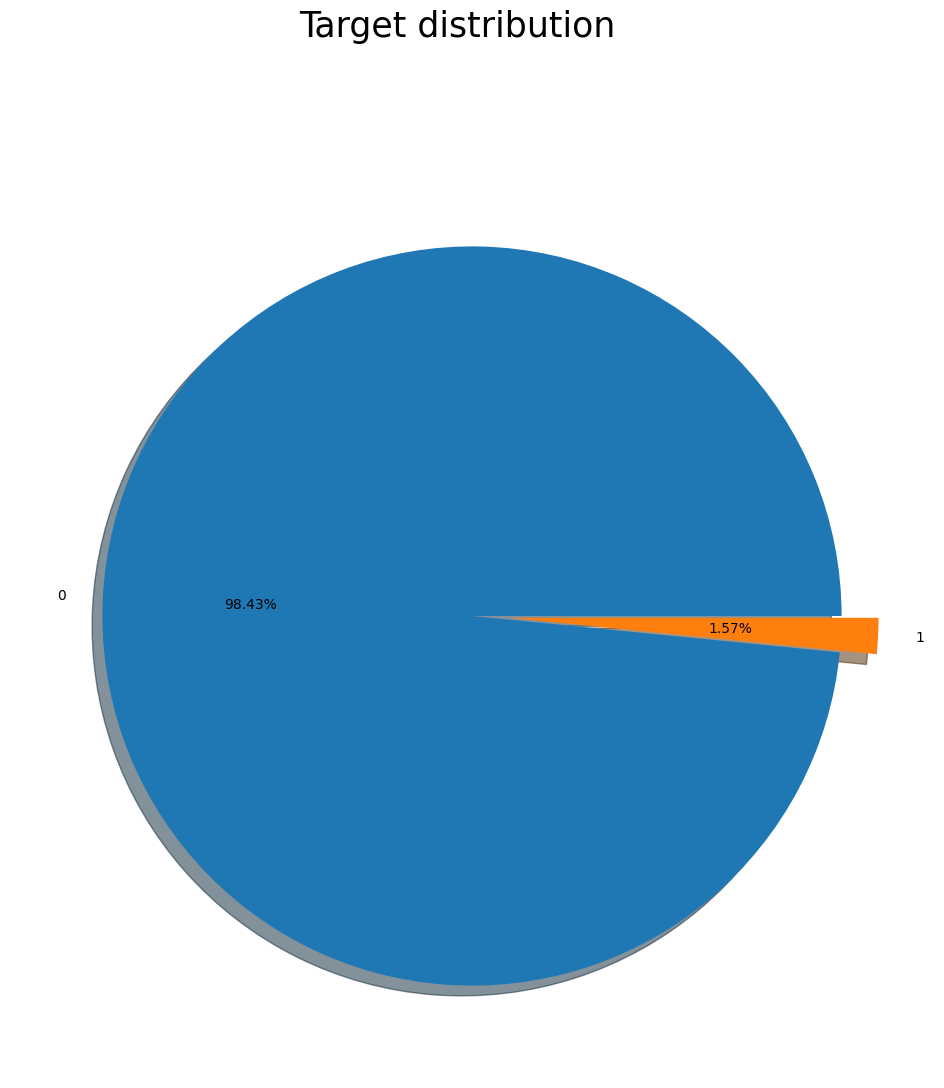

In [9]:
target = 'Machine failure'

target_train_perc = (100 * train[target].value_counts() / len(train)).round(2)

fig, ax = plt.subplots(1,1, figsize = (12, 12))
ax = plt.pie(target_train_perc.values, labels = target_train_perc.index, shadow = True, explode = [0., 0.1], autopct = '%.2f%%')
fig.suptitle('Target distribution', fontsize = 25, y = 1.0)

plt.show()

**Outtakes:**
<ul>
    <li>The target distribution is highly unbalanced, with very few failure observations w.r.t. proper working conditions.</li>
    <li>It follows that in a cross validation study it's preferable to split the data with an even distribution of the target values, for example using StratifiedKFold. </li>
</ul>

<h3 style="color:green">Missing Values</h3><a id="section_2_2"></a>

We check for the presence of missing values in both training and testing set:

In [10]:
def nan_finder(df):
    nan_Series = (df.isnull().sum() / len(df)).round(2)
    df_name = [x for x in globals() if globals()[x] is df][0]
    nan_Series.name = df_name + ' Nan freq.(%)'
    return nan_Series.sort_values(ascending = False)

sep('train')
display(nan_finder(train))

sep('test')
display(nan_finder(test))

--------------------------------------------------------------------------------
                                        TRAIN
--------------------------------------------------------------------------------


Product ID                 0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Machine failure            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
Power                      0.0
Name: train Nan freq.(%), dtype: float64

--------------------------------------------------------------------------------
                                        TEST
--------------------------------------------------------------------------------


Product ID                 0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
Power                      0.0
Name: test Nan freq.(%), dtype: float64

No missing values are present, therefore no imputing is necessary in data preprocessing.

<h3 style="color:green">Outliers</h3><a id="section_2_3"></a>

We produce boxplot for the numerical (high cardinality) features to study the presence of outliers:

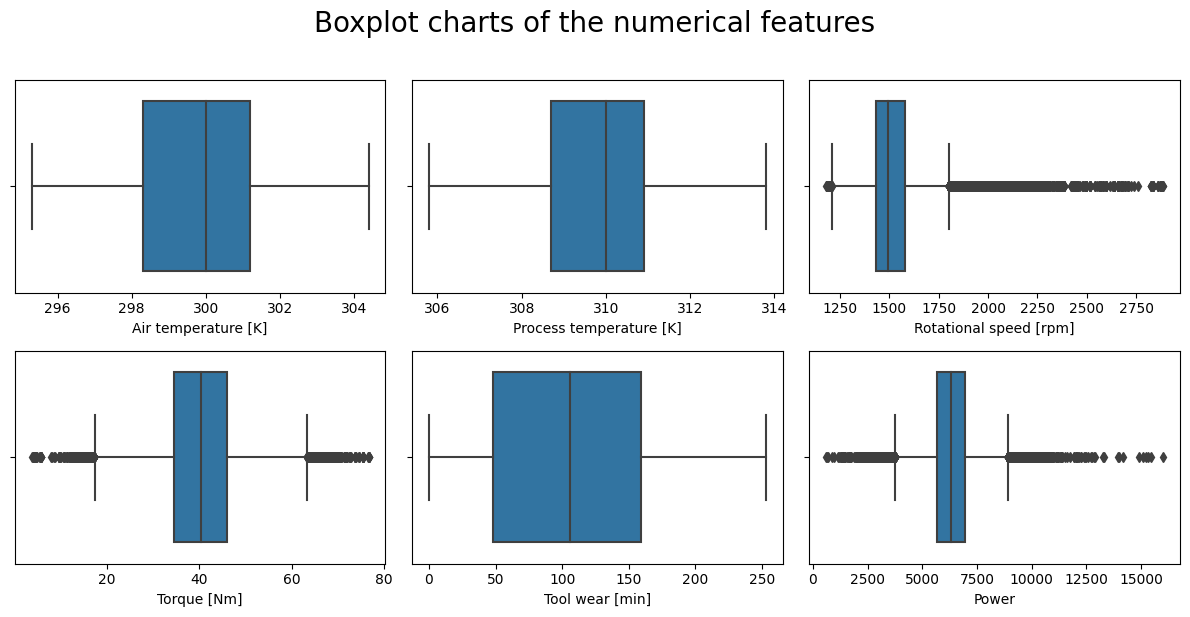

In [11]:
nhc_cols = [cname for cname in high_card_cols if train[cname].dtypes != 'object']

rows = int(np.ceil(len(nhc_cols) / 3))

_, axes = plt.subplots(rows, 3, figsize = (12, 6))
for feat, ax in zip(nhc_cols, axes.ravel()):
    sns.boxplot(x = train[feat], ax = ax)
plt.suptitle('Boxplot charts of the numerical features', fontsize = 20, y = 1.02)
plt.tight_layout(w_pad = 1)
plt.show()

Rotational speed, torque and power exhibits a significant presence of outliers, however these extremal data could be indicative of an anomalous regime of the machine that could lead to failure, so before eliminating them we study the failure frequency of the outliers data:

In [12]:
def outliers_failure_perc(df, feats, target):
    """
    For each feature passed as input we slice the dataframe to include only the data outside the 5%-95% quantiles range
    (the outliers) and calculate the failure frequency
    """
    failure_perc_dict = {}
    for feat in feats:
        outliers_df = df[(df[feat] < df[feat].quantile(0.05)) | (df[feat] > df[feat].quantile(0.95))]
        failure_perc = np.round(100 * len(outliers_df[outliers_df[target] == 1]) / len(outliers_df), 2)
        failure_perc_dict[feat] = failure_perc
    return failure_perc_dict

failure_perc_dict = outliers_failure_perc(train, ['Rotational speed [rpm]', 'Torque [Nm]', 'Power'], target)
display(failure_perc_dict)

{'Rotational speed [rpm]': 6.26, 'Torque [Nm]': 7.79, 'Power': 6.49}

**Outtakes:**
<ul>
    <li>The failure frequency of outliers is 4-5 time higher of the one of the full dataset, eliminating these points would therefore hides a relevant pattern, so we will keep all data.</li>
    <li>In preprocessing it will be useful to use StandardScaler as scaling imputer rather than MinMaxScaler, as it's more robust to handle outliers.</li>
</ul>

<h3 style="color:green">Feature Analysis</h3><a id="section_2_4"></a>

We study at first the training and test distribution of the numerical features of high cardinality, together with the target probability distribution:

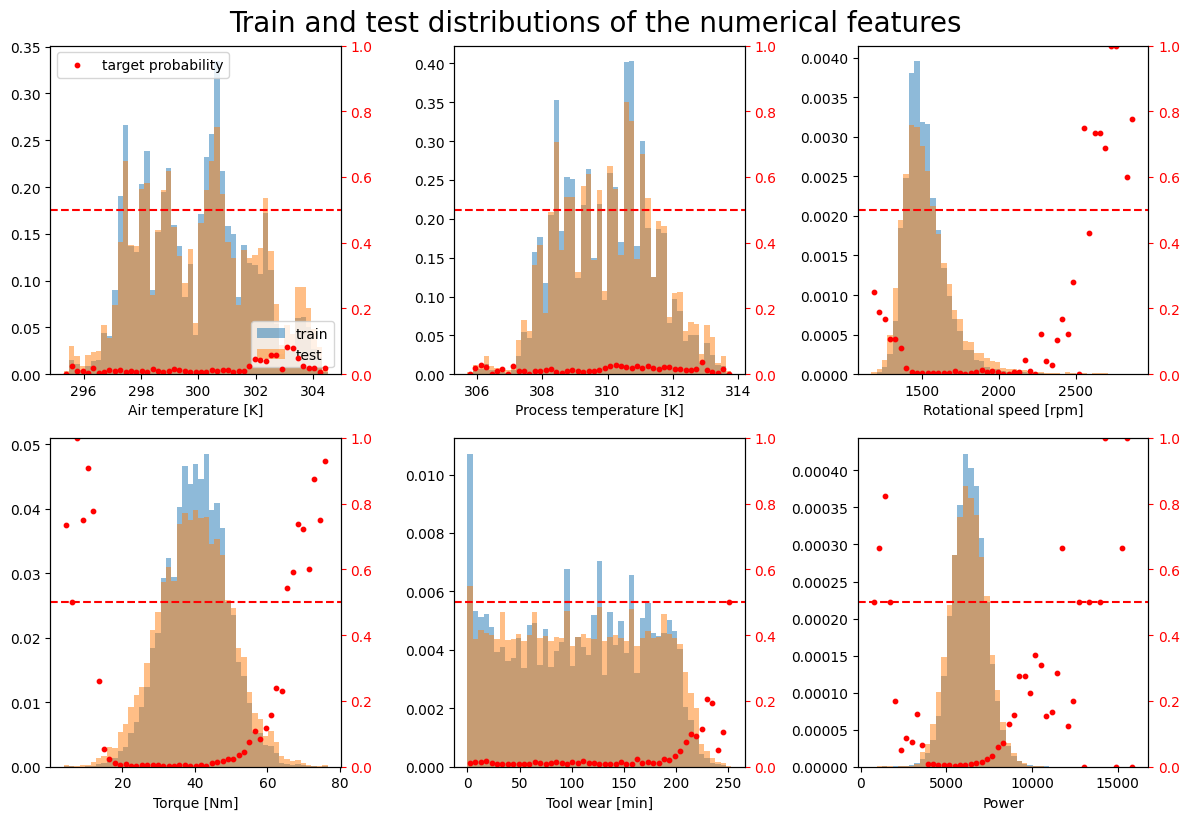

In [13]:
def plot_nhc_distr(train, test, nhc_cols, target):
    """
    train: training dataset
    test: tesing dataset
    nhc_cols: numerical, high-cardinality features to plot
    target: target feature
    Plot the features distribution for the training and target dataset in an histogram plot, for each bin
    the probability of positive target outcome (target == 1) it's displayed
    """
    rows = int(np.ceil(len(nhc_cols) / 3))
    _, axes = plt.subplots (rows, 3, figsize = (12, 8))
    for cname, ax in zip(nhc_cols, axes.ravel()):
        min_v = min(train[cname].min(), test[cname].min())
        max_v = max(train[cname].max(), test[cname].max())
        bins = np.linspace(min_v, max_v, 50)
        ax.hist(train[cname], bins = bins, alpha = 0.5, density = True, label = 'train')
        ax.hist(test[cname], bins = bins, alpha = 0.5, density = True, label = 'test')
        if ax == axes.flat[0] : ax.legend(loc = 'lower right')
        ax.set_xlabel(cname)
        
        ax2 = ax.twinx()
        with warnings.catch_warnings():
            warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
            total, _ = np.histogram(train[cname], bins = bins)
            tar_vals, _ = np.histogram(train[cname][train[target] == 1], bins = bins)
            ax2.scatter( (bins[1:] + bins[:-1]) / 2, tar_vals / total, color = 'r', s = 10, label = 'target probability')
            ax2.axhline(y = 0.5, color = 'r', linestyle = '--')
            ax2.set_ylim(0., 1.)
            ax2.tick_params(axis = 'y', colors = 'r')
            if ax == axes.flat[0] : ax2.legend(loc = 'upper left')
    plt.tight_layout()
    plt.suptitle('Train and test distributions of the numerical features', fontsize=20, y=1.02)
    plt.show()


nhc_cols = [cname for cname in high_card_cols if train[cname].dtypes != 'object']

plot_nhc_distr(train, test, nhc_cols = nhc_cols, target = target)

**Outtakes:**
<ul>
    <li>Train and test distribution for all features are fairly similar.</li>
    <li>Power and torque distribution are fairly normal, the tool wear distribution is fairly uniform and there isn't significant skewness.</li>
    <li>Air and process temperature seems not indicative to discern target probabilities.</li>
    <li>higher chances of failure appears for very low or very high value of torque/power, as well for prolonged tool wear as expected.</li>
</ul>

We perform a similar analysis for low cardinality features:

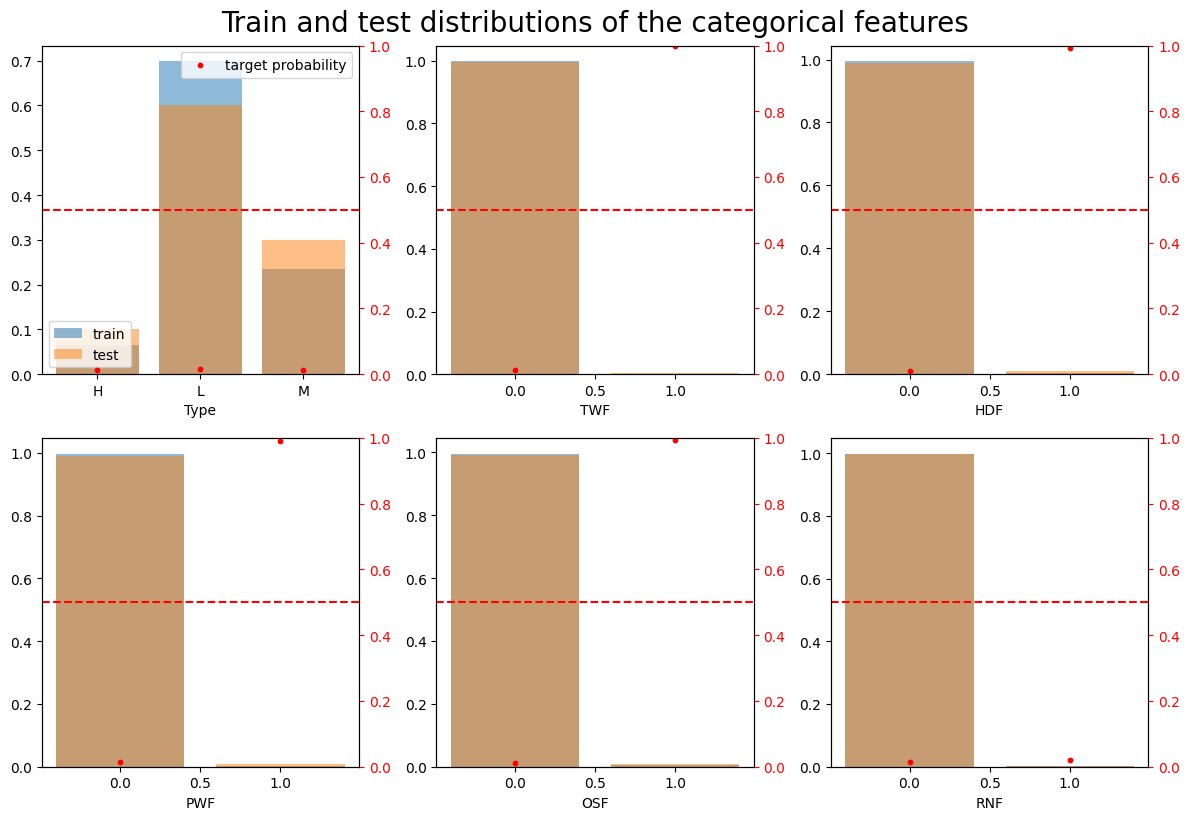

In [14]:
def plot_lc_distr(train, test, lc_cols, target):
    """
    train: training dataset
    test: tesing dataset
    lc_cols: numerical, low-cardinality features to plot
    target: target feature
    Plot the features distribution for the training and target dataset in an bar plot, for each class value
    the probability of positive target outcome (target == 1) it's displayed
    """
    rows = int(np.ceil(len(lc_cols)/3))
    _, axes = plt.subplots(rows, 3, figsize = (12, 8))

    for cname, ax in zip(lc_cols, axes.ravel()):
        train_gb = train[target].groupby(train[cname]).agg(['mean', 'size'])
        test_gb = test[cname].value_counts()
        ax.bar(train_gb.index, train_gb['size'] / len(train), alpha = 0.5, label = 'train')
        ax.bar(test_gb.index, test_gb / len(test), alpha = 0.5, label = 'test')
        ax.set_xlabel(cname)
        if ax == axes.flat[0] : ax.legend(loc = 'lower left')

        ax2 = ax.twinx()
        ax2.scatter(train_gb.index, train_gb['mean'], color = 'r', s = 10, label = 'target probability')
        ax2.set_ylim(0., 1.)
        ax2.axhline(y = 0.5, color = 'r', linestyle = '--')
        ax2.tick_params(axis = 'y', colors = 'r')
        if ax == axes.flat[0] : ax2.legend(loc = 'upper right')

    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the categorical features', fontsize=20, y=1.02)
    plt.show()
    del train_gb, test_gb

plot_lc_distr(train, test, low_card_cols, target)

**Outtakes:**
<ul>
    <li>Training and test distribution are rather similar for all features.</li>
    <li>The type of machine as well as the RNF features doesn't seem helpful to predict failure probability.</li>
    <li>While the TWF, HDF, PWF and OSF features are higly unbalanced we observe a significant difference in target probability and therefore are promising features.</li>
</ul>

<h3 style="color:green">Correlations</h3><a id="section_2_5"></a>

We study linear correlation for numerical features:

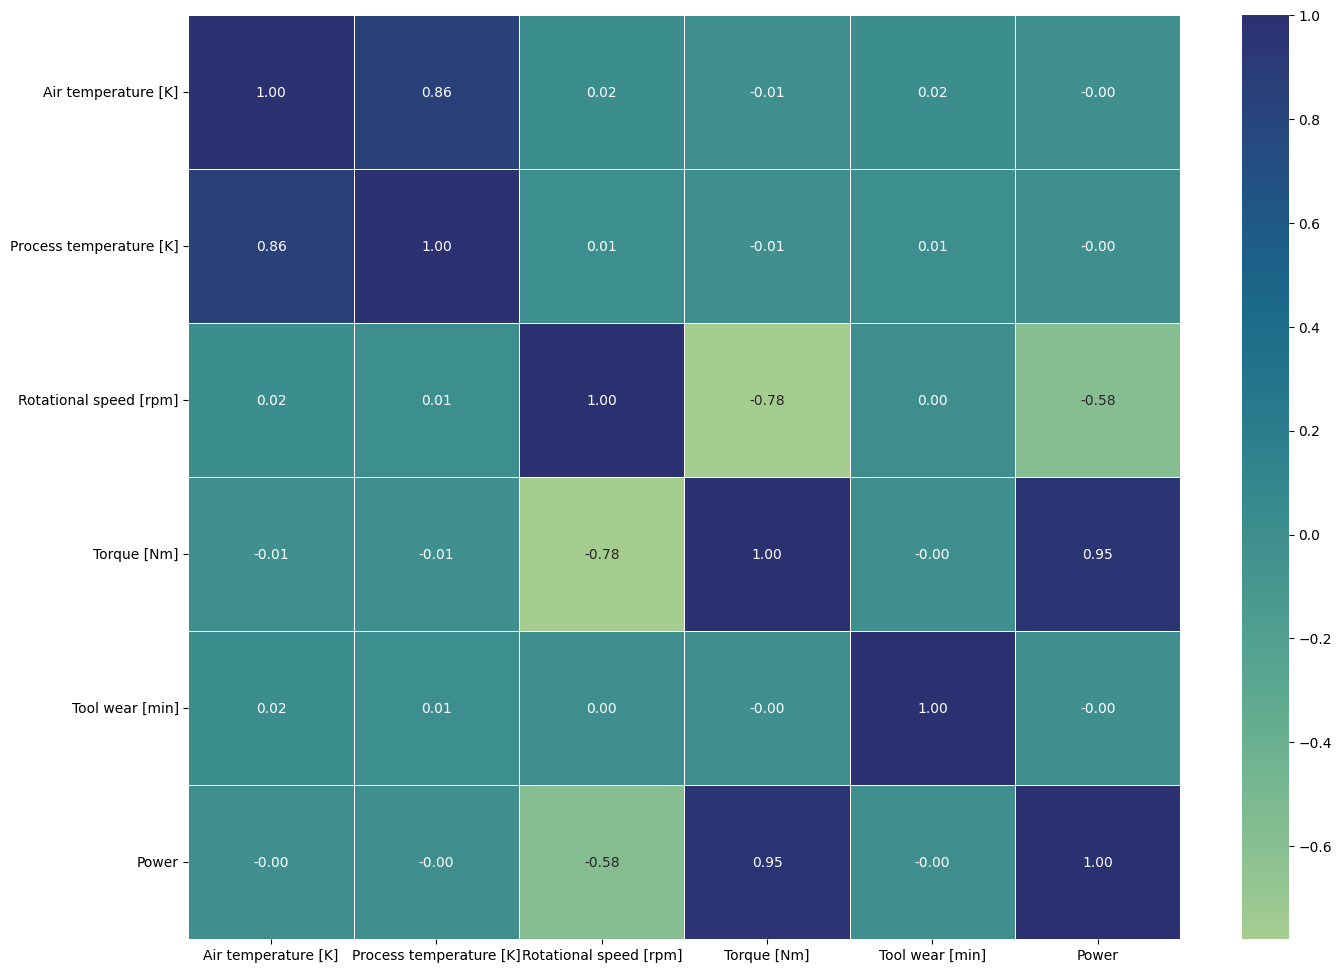

In [15]:
corr_cols = ['Air temperature [K]',
'Process temperature [K]',
'Rotational speed [rpm]',
'Torque [Nm]',
'Tool wear [min]', 'Power']

corr_matrix = train[corr_cols].corr()

_, ax = plt.subplots(1,1, figsize=(16, 12))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', linewidth = 0.5, cmap = 'crest', ax = ax)
plt.show()

**Outtakes:**
<ul>
    <li>Air and process temperature exhibits positive linear correlation: this could be expected (machines reach higher temperature in hotter environments), however the similarity in the ranges of air and process temperatures could be indicative of incorrect measurements/ bad sensor placement.</li>
    <li>Torque is higly positive correlated with power, as expected by the power formula, and is negatively correlated to the rotational speed.</li>
    <li>No other significant LINEAR correlation is detected.</li>
</ul>

In [16]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features)
    mi_Series = pd.Series(mi_scores, name = 'MI scores', index = X.columns)
    return mi_Series.sort_values(ascending=False)

X_temp = train.drop(target, axis = 1).copy()
y_temp = train[target]

for cname in X_temp.select_dtypes(include='object'):
    X_temp[cname], _ = X_temp[cname].factorize()

discrete_features = X_temp.dtypes == int
mi_scores = make_mi_scores(X_temp, y_temp, discrete_features = discrete_features)
del X_temp, y_temp
mi_scores

Product ID                 0.035404
HDF                        0.022171
Torque [Nm]                0.019828
Rotational speed [rpm]     0.019577
OSF                        0.016764
Power                      0.015515
PWF                        0.010276
Tool wear [min]            0.006691
TWF                        0.005878
Air temperature [K]        0.005134
Process temperature [K]    0.001843
Type                       0.000075
RNF                        0.000027
Name: MI scores, dtype: float64

We produce scatter plots of numerical, high-cardinality features with failure instances highlighted to look for meaningful patters:

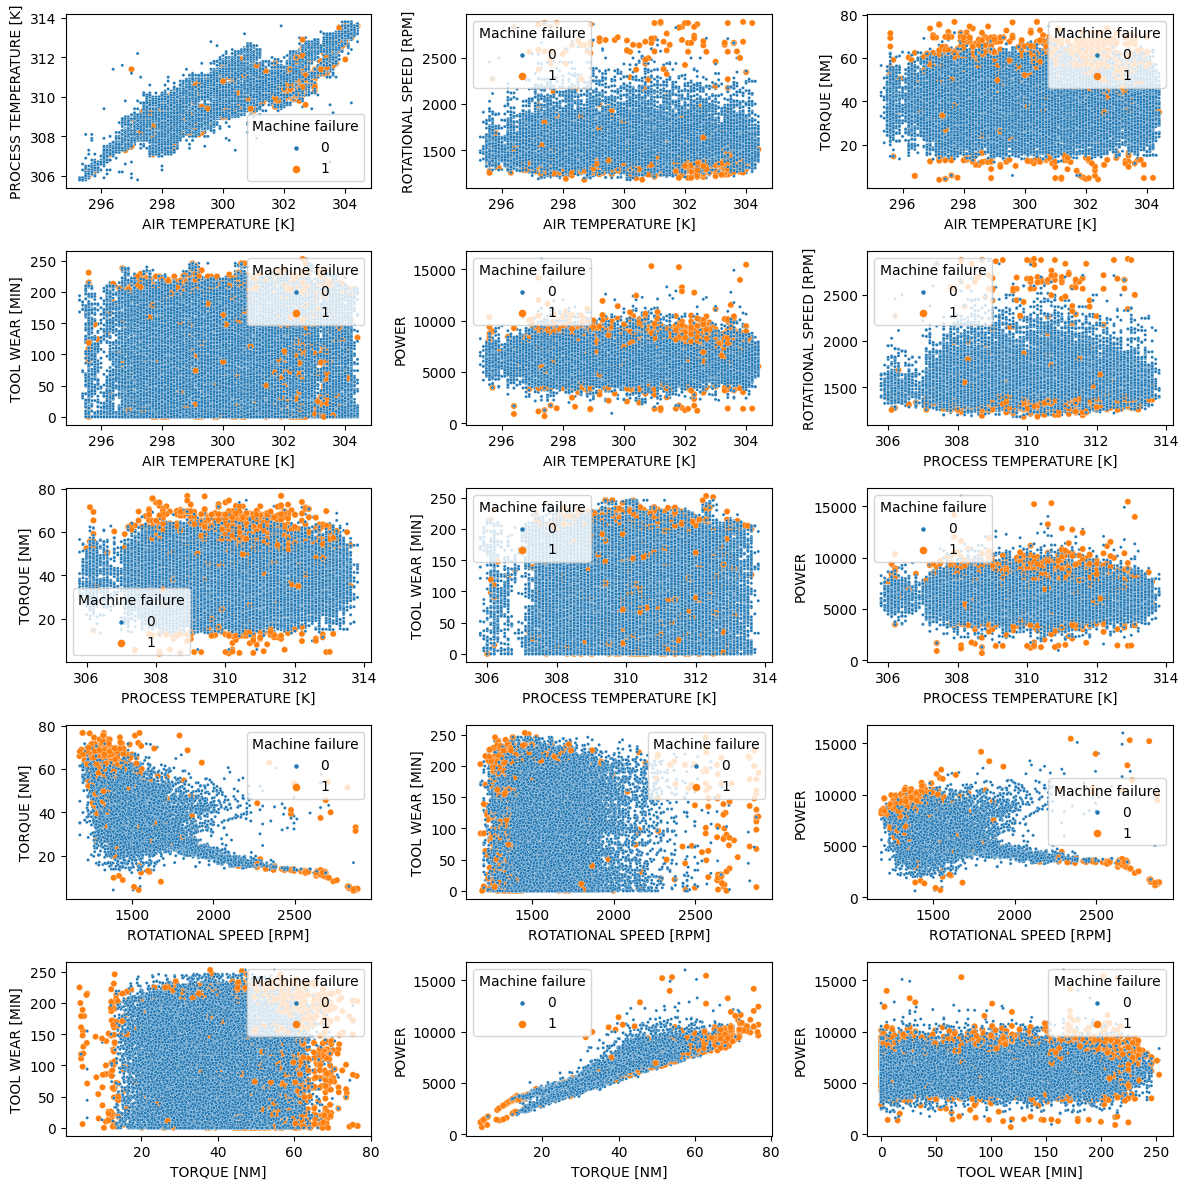

In [17]:
def scatter_feats(df, feats, target):
    """
    df: dataframe
    feats: features to plot
    target: target feature
    Plot scatter plot of each combination of the input features, separating by dots color and size failure and not-failure instances
    """
    num_plots = len(feats)*(len(feats) - 1)/2
    rows = int(np.ceil(num_plots / 3))
    _, axes = plt.subplots(rows, 3, figsize = (12, 12))
    count = 0
    for i in range(len(feats)):
        for j in range(i+1, len(feats)):
            ax_x = count // 3
            ax_y = count % 3
            sns.scatterplot(data = df, x = feats[i], y = feats[j], hue = target, size = target, sizes = (20, 5), ax = axes[ax_x, ax_y])
            axes[ax_x, ax_y].set_xlabel(feats[i].upper())
            axes[ax_x, ax_y].set_ylabel(feats[j].upper())
            count += 1
    plt.tight_layout(w_pad = 1)
    plt.show()

nhc_cols = [cname for cname in high_card_cols if train[cname].dtypes != 'object']
scatter_feats(train, nhc_cols, target)

**Outtakes:**
<ul>
    <li>Air and process temperature have a roughly linear relationship, however there isn't much searation between failure and not-failure data, to further suggest their limited importance for the classification task.</li>
    <li>The relation between power and torque is roughly linear (as expected, since it is linear for fixed rotational speed), the failure data points accumulate at the extremities of the scatter distribution.</li>
    <li>The relation between rotational speed and torque/power is interesting: at lower rotational speed both torque an power can vary substantially, but as the speed increases their values are more and more limited (except for some outliers); most failure data points are shown for low/high rotational speed, torque and power.</li>
    <li>The plots of power/torque and tool wear clearly show how extremal values of torque and power are indicative for failure, and in lesser measure the highest value of tool wear.</li>
</ul>

<h2 style="color:cyan">MODELS SETUP/PREDICTIONS</h2><a id="chapter3"></a>

<h3 style="color:green">Setup</h3><a id="section_3_1"></a>

For training we select the features deemed more significant from EDA, that is:
<ul>
    <li>Numerical features: Torque, Rotational speed, Power, Tool wear.</li>
    <li>Categorical features: TWF, HDF, PWF, OSF</li>
</ul>
To choose the best model/hyperparameters we perform a GridSearchCV considering:
<ul>
    <li>LogistiRegression</li>
    <li>XGBClassifier</li>
    <li>RandomForestClassifier</li>
    <li>Support Verctor Machine (SVC)</li>
</ul>
For preprocessing we just perform standard scaling to the numerical feature and one hot encoding for the categorical features:

In [18]:
num_feats = ['Tool wear [min]', 'Torque [Nm]', 'Power', 'Rotational speed [rpm]']
cat_feats = ['TWF', 'HDF', 'PWF', 'OSF']

X_train = train[num_feats + cat_feats]
y_train = train[target]

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

model_dict = {
    'LR' : LogisticRegression(),
    'XGB' : XGBClassifier(),
    'RFC' : RandomForestClassifier(),
    'SVC' : SVC()
}

params_dict = {
    'LR' : {'model__C' : [0.1, 1., 10.], 'model__max_iter' : [500], 'model__class_weight' : ['balanced']},
    'XGB' : {'model__n_estimators' : [50, 100] ,'model__max_depth' : [8, 10, 12], 'model__learning_rate' : [1e-3, 1e-2, 1e-1]},
    'RFC' : {'model__n_estimators' : [50, 100, 200], 'model__max_depth' : [8, 10, 12], 'model__min_samples_leaf' : [1, 3, 5]},
    'SVC' : {'model__C' : [0.05] , 'model__gamma' : [0.05, 0.5]
    }
}

In [19]:
i = 0
best_model_params = model_dict.copy()

grid_results = pd.DataFrame({'MODEL' : model_dict.keys(), 'BEST_SCORE' : np.zeros(len(model_dict)), 
                            'BEST_PARAMS' : np.zeros(len(model_dict)) ,'TIME' : np.zeros(len(model_dict))})

for key, model in model_dict.items():
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)

        print(model)
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor_pipeline),
            ('model', model)
        ])
        
        start = time.time()
        cross_validation = StratifiedKFold(n_splits = 5, shuffle = True)
        model_gscv = GridSearchCV(full_pipeline, param_grid = params_dict[key], cv = cross_validation , scoring = 'roc_auc', n_jobs = -1)
        model_gscv.fit(X_train, y_train)
        stop = time.time()

        grid_results.iloc[i, 1] = model_gscv.best_score_
        grid_results.iloc[i, 2] = str(model_gscv.best_params_)
        grid_results.iloc[i, 3] = np.round(stop - start, 2)

        best_model_params[key] = model_gscv.best_params_

        print('Model: ', key)
        print('Training time (s): ', grid_results.iloc[i, 3])
        print('')

        i += 1

LogisticRegression()
Model:  LR
Training time (s):  8.7

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Model:  XGB
Training time (s):  31.47

RandomForestClassifier()
Model:  RFC
Training time (s):  570.23

SVC()
Model:  SVC
Training time (s):  188.83



In [20]:
display(grid_results)
display(best_model_params)

,MODEL,BEST_SCORE,BEST_PARAMS,TIME
0,LR,0.940397,"{'model__C': 0.1, 'model__class_weight': 'bala...",8.70
1,XGB,0.960066,"{'model__learning_rate': 0.1, 'model__max_dept...",31.47
2,RFC,0.959974,"{'model__max_depth': 12, 'model__min_samples_l...",570.23
3,SVC,0.903838,"{'model__C': 0.05, 'model__gamma': 0.05}",188.83


{'LR': {'model__C': 0.1,
  'model__class_weight': 'balanced',
  'model__max_iter': 500},
 'XGB': {'model__learning_rate': 0.1,
  'model__max_depth': 8,
  'model__n_estimators': 100},
 'RFC': {'model__max_depth': 12,
  'model__min_samples_leaf': 1,
  'model__n_estimators': 50},
 'SVC': {'model__C': 0.05, 'model__gamma': 0.05}}

XGBClassifier followed closely by the RandomForestClassifier have the best performance.

<h3 style="color:green">Predictions</h3><a id="section_3_2"></a>

Finally to get the predictions we train the XGBClassifier with the best hyperparameters on the whole training set:

In [21]:
best_estimator = XGBClassifier(n_estimators = 100, max_depth = 8, learning_rate = 0.1)
best_pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', best_estimator)
])

best_pipeline.fit(X_train, y_train)
X_test = test[num_feats + cat_feats]
y_test = best_pipeline.predict_proba(X_test)

In [22]:
print(y_test[:10])

[[9.9959469e-01 4.0532197e-04]
 [9.9702555e-01 2.9744231e-03]
 [9.9841946e-01 1.5805516e-03]
 [9.9933225e-01 6.6774071e-04]
 [9.9803376e-01 1.9662271e-03]
 [9.9602234e-01 3.9776275e-03]
 [9.9960756e-01 3.9243198e-04]
 [9.9945062e-01 5.4936111e-04]
 [9.9616748e-01 3.8325456e-03]
 [9.9813700e-01 1.8629753e-03]]


The probability of failure is on column 1.

In [23]:
submission_df = pd.DataFrame({'id': np.arange(0, len(y_test),1), 'Machine failure': y_test[:,1]})
submission_df.to_csv('machine_failure_submission.csv', index=False)

The AUC score of the test dataset is of 0.99604.